![header1](../figures/dc_2024_4dmedsea_banner.jpg) 

# Benchmark exp_20162017 MIOST sea surface height maps (Geostrophic mode only)
 

***
**Authors:**  CLS & Datlas <br>
**Copyright:** 2023 CLS & Datlas <br>
**License:** MIT

<div class="alert alert-block alert-success">
<h1><center>Benchmark exp_20162017 of MIOST sea surface height maps</center></h1> 
</div>

***
**General Note 1**: Execute each cell through the <button class="btn btn-default btn-xs"><i class="icon-play fa fa-play"></i></button> button from the top MENU (or keyboard shortcut `Shift` + `Enter`).<br>
<br>
**General Note 2**: If, for any reason, the kernel is not working anymore, in the top MENU, click on the <button class="btn btn-default btn-xs"><i class="fa fa-repeat icon-repeat"></i></button> button. Then, in the top MENU, click on "Cell" and select "Run All Above Selected Cell".<br>
***


<div class="alert alert-danger" role="alert">

<h3>Learning outcomes</h3>

At the end of this notebook you will know:
<ul>
  <li>How you can evaluated sea surface height maps with independent alongtrack data: statistical and spectral analysis</li>
</ul>
    
</div>

In [1]:
from glob import glob
import numpy as np
import os
import sys 

In [2]:
sys.path.append('../')
from src.mod_plot import *
from src.mod_stat import *
from src.mod_spectral import *
from src.mod_interp import *

In [3]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

<div class="alert alert-info" role="alert">

<h2>0. Parameters</h2>

</div>

In [4]:
time_min = '2016-01-08'                                        # time min for analysis
time_max = '2017-06-23'                                        # time max for analysis
output_dir = '../results'                                      # output directory path
os.system(f'mkdir -p {output_dir}')

box_lonlat = {'lon_min':-6,
              'lon_max':36,
              'lat_min':30,
              'lat_max':46 }

method_name = 'MIOST'

stat_output_filename = f'{output_dir}/stat_exp_20162017_sla_'+method_name+'.nc'  # output statistical analysis filename
lambda_min = 65.                                               # minimun spatial scale in kilometer to consider on the filtered signal
lambda_max = 500.                                              # maximum spatial scale in kilometer to consider on the filtered signal
rmse_filename = f'{output_dir}/rmse_exp_20162017_sla_'+method_name+'.nc'
psd_output_filename = f'{output_dir}/psd_exp_20162017_sla_'+method_name+'.nc'    # output spectral analysis filename
segment_lenght = 500.                                         # spectral parameer: along-track segment lenght in kilometer to consider in the spectral analysis

<div class="alert alert-info" role="alert">

<h2>1. Input files</h2>

</div>

## Sea Surface Height from Saral/AltiKa

In [5]:
list_of_file = sorted(glob('../data/exp_20162017/eval/indep_nadirs/h2ag/*/*.nc'))
ds_h2a = xr.open_mfdataset(list_of_file, combine='nested', concat_dim='time')
ds_h2a = ds_h2a.where((ds_h2a.time >= np.datetime64(time_min)) & (ds_h2a.time <=  np.datetime64(time_max)), drop=True)
ds_h2a = ds_h2a.sortby('time')
ds_h2a

<xarray.Dataset>
Dimensions:         (time: 1074424)
Coordinates:
  * time            (time) datetime64[ns] 2016-03-31T04:59:13.500000 ... 2017...
    longitude       (time) float64 dask.array<chunksize=(2685,), meta=np.ndarray>
    latitude        (time) float64 dask.array<chunksize=(2685,), meta=np.ndarray>
Data variables:
    cycle           (time) float64 dask.array<chunksize=(2685,), meta=np.ndarray>
    track           (time) float64 dask.array<chunksize=(2685,), meta=np.ndarray>
    sla_unfiltered  (time) float32 dask.array<chunksize=(2685,), meta=np.ndarray>
    sla_filtered    (time) float32 dask.array<chunksize=(2685,), meta=np.ndarray>
    dac             (time) float32 dask.array<chunksize=(2685,), meta=np.ndarray>
    ocean_tide      (time) float32 dask.array<chunksize=(2685,), meta=np.ndarray>
    internal_tide   (time) float32 dask.array<chunksize=(2685,), meta=np.ndarray>
    lwe             (time) float32 dask.array<chunksize=(2685,), meta=np.ndarray>
    mdt             (time) float32 dask.array<chunksize=(2685,), meta=np.ndarray>
    tpa_correction  (time) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes: (12/44)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Swath
    comment:                         Sea surface height measured by altimeter...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    ...                              ...
    summary:                         SSALTO/DUACS Delayed-Time Level-3 sea su...
    time_coverage_duration:          P15H17M41.448000S
    time_coverage_end:               2016-03-31T20:16:54Z
    time_coverage_resolution:        P1S
    time_coverage_start:             2016-03-31T04:59:13Z
    title:                           DT Haiyang-2A Geodetic Phase European Se...

## Sea Surface Height maps to evaluate

In [6]:
list_of_maps = sorted(glob('../data/exp_20162017/maps/maps_miost/*.nc'))
ds_maps = xr.open_mfdataset(list_of_maps, combine='nested', concat_dim='time')
ds_maps = ds_maps.sel(time=slice(time_min, time_max))
ds_maps

<xarray.Dataset>
Dimensions:             (longitude: 1012, latitude: 378, time: 533)
Coordinates:
  * longitude           (longitude) float32 -6.062 -6.021 -5.979 ... 36.02 36.06
  * latitude            (latitude) float32 30.27 30.31 30.35 ... 45.94 45.98
  * time                (time) datetime64[ns] 2016-01-08 ... 2017-06-23
Data variables:
    sla                 (time, latitude, longitude) float64 dask.array<chunksize=(1, 378, 1012), meta=np.ndarray>
    ugosa               (time, latitude, longitude) float64 dask.array<chunksize=(1, 378, 1012), meta=np.ndarray>
    vgosa               (time, latitude, longitude) float64 dask.array<chunksize=(1, 378, 1012), meta=np.ndarray>
    relative_vorticity  (time, latitude, longitude) float64 dask.array<chunksize=(1, 378, 1012), meta=np.ndarray>
    adt                 (time, latitude, longitude) float64 dask.array<chunksize=(1, 378, 1012), meta=np.ndarray>
    ugos                (time, latitude, longitude) float64 dask.array<chunksize=(1, 378, 1012), meta=np.ndarray>
    vgos                (time, latitude, longitude) float64 dask.array<chunksize=(1, 378, 1012), meta=np.ndarray>

<div class="alert alert-info" role="alert">

<h2>2. Statistical & Spectral Analysis </h2>

</div>

## 2.1 Interpolate sea surface height maps onto along-track positions

In [7]:
ds_interp = run_interpolation(ds_maps, ds_h2a)
ds_interp = ds_interp.dropna('time')
ds_interp

2024-05-02 10:28:12 INFO     fetch data from 2016-02-29 00:00:00 to 2016-04-01 00:00:00
2024-05-02 10:28:13 INFO     fetch data from 2016-03-31 00:00:00 to 2016-05-01 00:00:00
2024-05-02 10:28:14 INFO     fetch data from 2016-04-30 00:00:00 to 2016-06-01 00:00:00
2024-05-02 10:28:15 INFO     fetch data from 2016-05-31 00:00:00 to 2016-07-01 00:00:00
2024-05-02 10:28:16 INFO     fetch data from 2016-06-30 00:00:00 to 2016-08-01 00:00:00
2024-05-02 10:28:17 INFO     fetch data from 2016-07-31 00:00:00 to 2016-09-01 00:00:00
2024-05-02 10:28:18 INFO     fetch data from 2016-08-31 00:00:00 to 2016-10-01 00:00:00
2024-05-02 10:28:18 INFO     fetch data from 2016-09-30 00:00:00 to 2016-11-01 00:00:00
2024-05-02 10:28:19 INFO     fetch data from 2016-10-31 00:00:00 to 2016-12-01 00:00:00
2024-05-02 10:28:20 INFO     fetch data from 2016-11-30 00:00:00 to 2017-01-01 00:00:00
2024-05-02 10:28:20 INFO     fetch data from 2016-12-31 00:00:00 to 2017-02-01 00:00:00
2024-05-02 10:28:21 INFO     fet

<xarray.Dataset>
Dimensions:            (time: 146595)
Coordinates:
  * time               (time) datetime64[ns] 2016-03-31T05:08:24.412000 ... 2...
Data variables: (12/13)
    cycle              (time) float64 118.0 118.0 118.0 ... 168.0 168.0 168.0
    track              (time) float64 198.0 198.0 198.0 ... 159.0 159.0 159.0
    sla_unfiltered     (time) float32 0.019 -0.005 -0.079 ... 0.084 0.131 0.094
    sla_filtered       (time) float32 0.002 -0.023 -0.039 ... 0.094 0.086 0.077
    dac                (time) float32 -0.105 -0.105 -0.104 ... -0.086 -0.086
    ocean_tide         (time) float32 0.003 0.003 0.004 ... -0.794 -0.791 -0.788
    ...                 ...
    lwe                (time) float32 -0.003 -0.003 -0.003 ... -0.009 -0.009
    mdt                (time) float32 -0.061 -0.063 -0.066 ... 0.015 0.014 0.013
    tpa_correction     (time) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    longitude          (time) float64 25.16 25.14 25.12 ... 354.0 354.0 354.0
    latitude           (time) float64 40.59 40.54 40.48 ... 45.4 45.45 45.51
    msla_interpolated  (time) float64 0.02124 0.01436 ... 0.07442 0.07391

## 2.2 Compute grid boxes statistics & statistics by regime (coastal, offshore low variability, offshore high variability)

In [8]:
compute_stat_scores(ds_interp, lambda_min, lambda_max, stat_output_filename, method_name)

2024-05-02 10:29:18 INFO     Compute mapping error all scales
2024-05-02 10:29:18 INFO     Compute mapping error for scales between 65.0 and 500.0 km


Total RMSE= 0.04695508099884804 m
Total RMSE score= 0.5389605712342556


2024-05-02 10:29:19 INFO     Compute binning statistics
2024-05-02 10:29:21 INFO     Compute statistics by oceanic regime
2024-05-02 10:29:41 INFO     Stat file saved as: ../results/stat_exp_20162017_sla_MIOST.nc


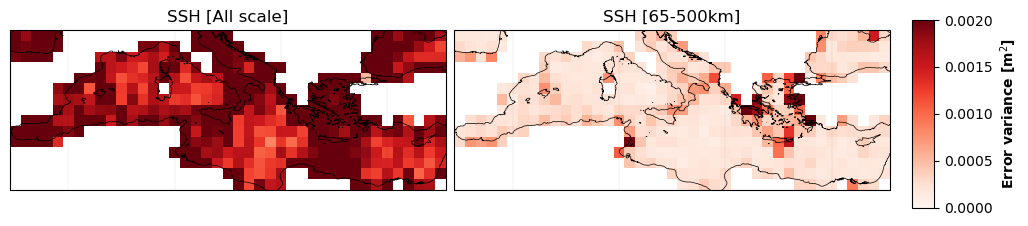

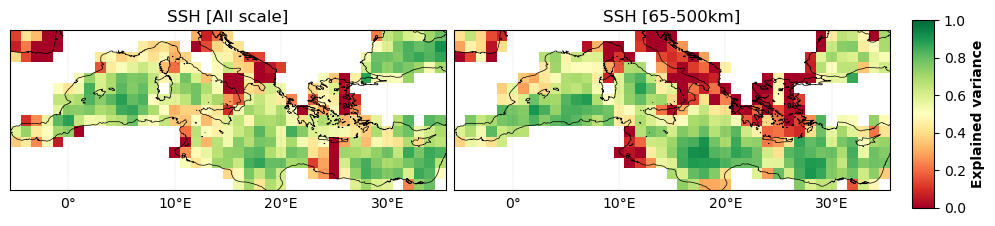

In [9]:
# Plot gridded stats 
plot_stat_score_map_png(stat_output_filename,region='4DMedSea',box_lonlat=box_lonlat)

## 2.3 Compute & plot temporal RMSE

In [10]:
compute_temporal_rmse(ds_interp, method_name, time_min, time_max, rmse_filename)

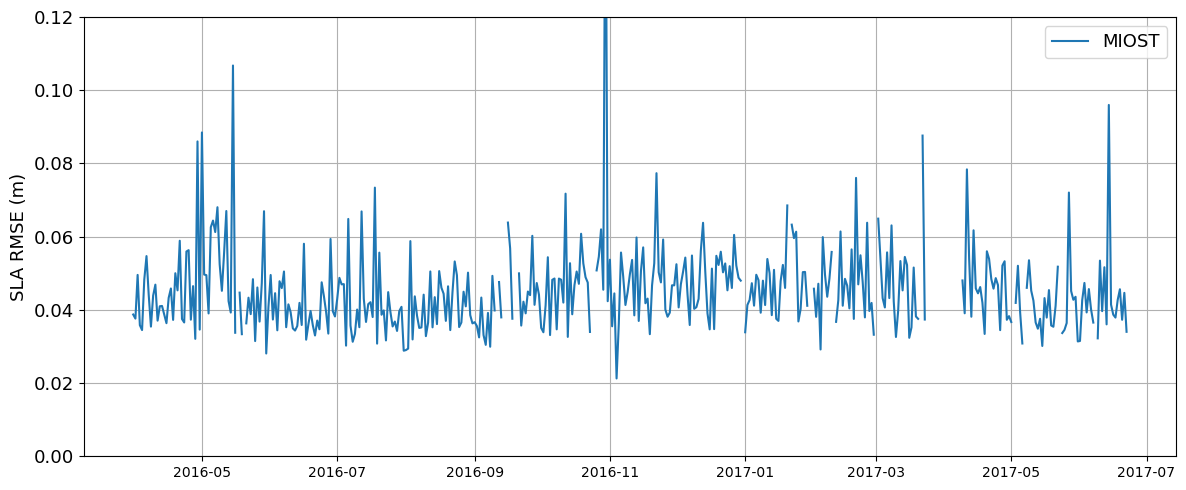

In [11]:
plot_temporal_rmse(rmse_filename)

## 2.4 Compute Spectral scores

In [12]:
compute_psd_scores_v2(ds_interp, psd_output_filename, lenght_scale=segment_lenght, method_name=method_name)

2024-05-02 10:32:02 INFO     Segment computation...
2024-05-02 10:32:02 INFO     Spectral analysis...
2024-05-02 10:32:07 INFO     Saving ouput...
2024-05-02 10:32:09 INFO     PSD file saved as: ../results/psd_exp_20162017_sla_MIOST.nc


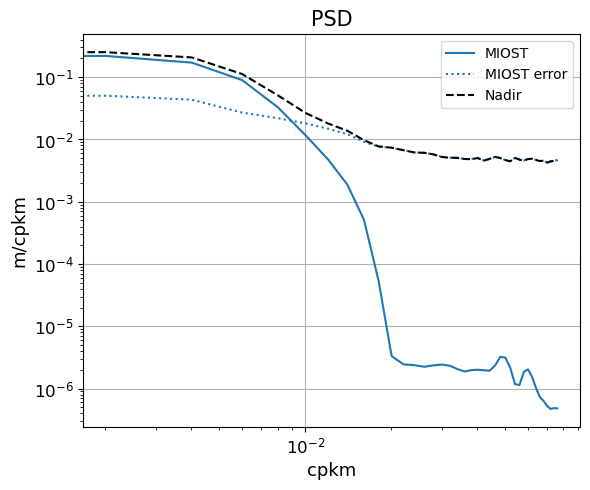

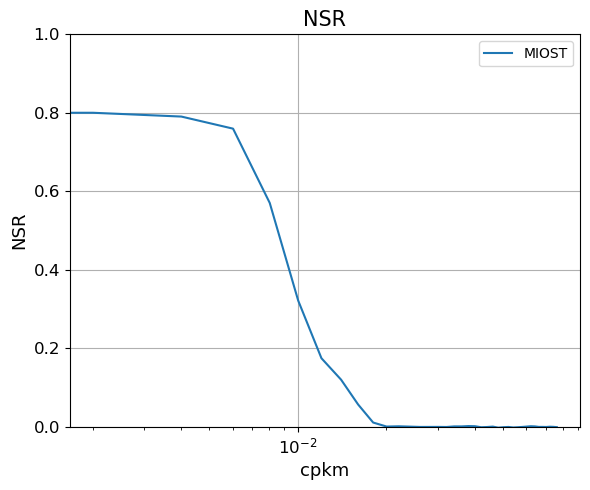

In [13]:
plot_average_psd(psd_output_filename)

Averaged effective resolution: 116.44566581056458 km


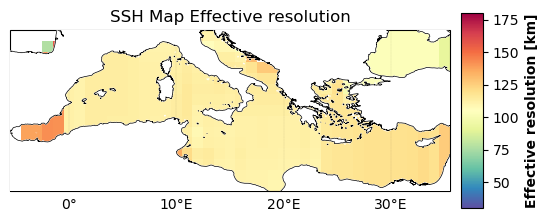

In [15]:
# Plot effective resolution 
plot_effective_resolution_png(psd_output_filename,region='4DMedSea',box_lonlat=box_lonlat, max_resol=180)